In [4]:
import os
import json
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

def load_experiment_data(filename):
    """
    Load the experiment results from a JSON file.
    
    Args:
        filename: Path to the results JSON file
        
    Returns:
        Pandas DataFrame with the experiment results
    """
    print(f"Loading data from {filename}...")
    
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Check if this is the all_results file directly
    if isinstance(data, list) and len(data) > 0 and 'ibfs_config' in data[0]:
        results = data
    # Check if this is the experiment_id_analysis.json file
    elif 'summary' in data:
        # We need to find and load the corresponding all_results file
        experiment_id = data.get('experiment_id')
        base_dir = os.path.dirname(filename)
        all_results_file = os.path.join(base_dir, f"{experiment_id}_all_results.json")
        
        if os.path.exists(all_results_file):
            print(f"Found associated all_results file: {all_results_file}")
            with open(all_results_file, 'r') as f:
                results = json.load(f)
        else:
            # Need to reconstruct from individual simulation files
            print(f"No all_results file found. Reconstructing from individual simulation files...")
            results = []
            for file in os.listdir(base_dir):
                if file.startswith(experiment_id) and file.endswith(".json") and "_sim_" in file:
                    with open(os.path.join(base_dir, file), 'r') as f:
                        try:
                            sim_data = json.load(f)
                            results.append(sim_data)
                        except json.JSONDecodeError:
                            print(f"Error loading {file} - skipping")
    else:
        raise ValueError("Unrecognized file format. Please provide an experiment results file.")
    
    # Filter out any results with errors
    valid_results = [r for r in results if 'error' not in r]
    
    # Convert to DataFrame for easier analysis
    rows = []
    for result in valid_results:
        # Extract the core configuration
        row = {
            'query': result.get('query', ''),
            'similarity_score': result.get('similarity_score', 0),
            'diversity_level': result.get('ibfs_config', {}).get('diversity_level', ''),
            'branching_factor': result.get('ibfs_config', {}).get('branching_factor', 0),
            'max_depth': result.get('ibfs_config', {}).get('max_depth', 0),
            'epsilon': result.get('user_config', {}).get('epsilon', 0),
            'strategy_path': result.get('strategy_path', []),
            'path_length': len(result.get('strategy_path', [])),
            'experiment_id': result.get('experiment_id', '')
        }
        rows.append(row)
    
    df = pd.DataFrame(rows)
    print(f"Loaded {len(df)} valid results")
    return df

def create_output_directory(experiment_id):
    """Create an output directory for analysis artifacts."""
    output_dir = f"analysis_output_{experiment_id}"
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def plot_similarity_by_parameter(df, parameter, output_dir):
    """
    Create a box plot showing similarity scores grouped by a parameter.
    
    Args:
        df: DataFrame with experiment results
        parameter: The parameter to group by (e.g., 'diversity_level')
        output_dir: Directory to save the plot
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=parameter, y='similarity_score', data=df)
    plt.title(f'Similarity Scores by {parameter}')
    plt.ylabel('Similarity Score')
    plt.xlabel(parameter.replace('_', ' ').title())
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save the figure
    filename = os.path.join(output_dir, f'similarity_by_{parameter}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {filename}")

def plot_parameter_interaction(df, param1, param2, output_dir):
    """
    Create a heatmap showing the interaction between two parameters.
    
    Args:
        df: DataFrame with experiment results
        param1: First parameter (e.g., 'branching_factor')
        param2: Second parameter (e.g., 'max_depth')
        output_dir: Directory to save the plot
    """
    # Group by both parameters and calculate mean similarity score
    grouped = df.groupby([param1, param2])['similarity_score'].mean().reset_index()
    pivot_table = grouped.pivot(index=param1, columns=param2, values='similarity_score')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'Avg Similarity Score'})
    plt.title(f'Interaction between {param1} and {param2}')
    plt.xlabel(param2.replace('_', ' ').title())
    plt.ylabel(param1.replace('_', ' ').title())
    
    # Save the figure
    filename = os.path.join(output_dir, f'interaction_{param1}_{param2}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {filename}")

def run_statistical_tests(df, output_dir):
    """
    Run statistical tests to determine significant effects.
    
    Args:
        df: DataFrame with experiment results
        output_dir: Directory to save the results
    """
    test_results = {}
    
    # Test for effect of diversity level
    if 'diversity_level' in df.columns and len(df['diversity_level'].unique()) > 1:
        groups = [df[df['diversity_level'] == level]['similarity_score'].values 
                 for level in df['diversity_level'].unique()]
        
        # ANOVA test if we have more than 2 groups
        if len(groups) > 2:
            f_stat, p_value = stats.f_oneway(*groups)
            test_results['diversity_level_anova'] = {
                'test': 'ANOVA',
                'F_statistic': float(f_stat),
                'p_value': float(p_value),
                'significant': p_value < 0.05
            }
        # T-test if we have exactly 2 groups
        elif len(groups) == 2:
            t_stat, p_value = stats.ttest_ind(groups[0], groups[1], equal_var=False)
            test_results['diversity_level_ttest'] = {
                'test': 't-test',
                'groups': list(df['diversity_level'].unique()),
                't_statistic': float(t_stat),
                'p_value': float(p_value),
                'significant': p_value < 0.05
            }
    
    # Test for effect of branching factor
    if 'branching_factor' in df.columns and len(df['branching_factor'].unique()) > 1:
        groups = [df[df['branching_factor'] == b]['similarity_score'].values 
                 for b in sorted(df['branching_factor'].unique())]
        
        if len(groups) > 2:
            f_stat, p_value = stats.f_oneway(*groups)
            test_results['branching_factor_anova'] = {
                'test': 'ANOVA',
                'F_statistic': float(f_stat),
                'p_value': float(p_value),
                'significant': p_value < 0.05
            }
        elif len(groups) == 2:
            t_stat, p_value = stats.ttest_ind(groups[0], groups[1], equal_var=False)
            test_results['branching_factor_ttest'] = {
                'test': 't-test',
                'groups': list(sorted(df['branching_factor'].unique())),
                't_statistic': float(t_stat),
                'p_value': float(p_value),
                'significant': p_value < 0.05
            }
    
    # Test for effect of max depth
    if 'max_depth' in df.columns and len(df['max_depth'].unique()) > 1:
        groups = [df[df['max_depth'] == d]['similarity_score'].values 
                 for d in sorted(df['max_depth'].unique())]
        
        if len(groups) > 2:
            f_stat, p_value = stats.f_oneway(*groups)
            test_results['max_depth_anova'] = {
                'test': 'ANOVA',
                'F_statistic': float(f_stat),
                'p_value': float(p_value),
                'significant': p_value < 0.05
            }
        elif len(groups) == 2:
            t_stat, p_value = stats.ttest_ind(groups[0], groups[1], equal_var=False)
            test_results['max_depth_ttest'] = {
                'test': 't-test',
                'groups': list(sorted(df['max_depth'].unique())),
                't_statistic': float(t_stat),
                'p_value': float(p_value),
                'significant': p_value < 0.05
            }
    
    # Test for effect of epsilon
    if 'epsilon' in df.columns and len(df['epsilon'].unique()) > 1:
        groups = [df[df['epsilon'] == e]['similarity_score'].values 
                 for e in sorted(df['epsilon'].unique())]
        
        if len(groups) > 2:
            f_stat, p_value = stats.f_oneway(*groups)
            test_results['epsilon_anova'] = {
                'test': 'ANOVA',
                'F_statistic': float(f_stat),
                'p_value': float(p_value),
                'significant': p_value < 0.05
            }
        elif len(groups) == 2:
            t_stat, p_value = stats.ttest_ind(groups[0], groups[1], equal_var=False)
            test_results['epsilon_ttest'] = {
                'test': 't-test',
                'groups': list(sorted(df['epsilon'].unique())),
                't_statistic': float(t_stat),
                'p_value': float(p_value),
                'significant': p_value < 0.05
            }
    
    # Save the test results
    with open(os.path.join(output_dir, 'statistical_tests.json'), 'w') as f:
        json.dump(test_results, f, indent=2)
    
    # Also save a human-readable summary
    with open(os.path.join(output_dir, 'statistical_tests_summary.txt'), 'w') as f:
        f.write("Statistical Test Results Summary\n")
        f.write("===============================\n\n")
        
        for test_name, result in test_results.items():
            f.write(f"Test: {test_name}\n")
            f.write(f"Type: {result['test']}\n")
            if 'groups' in result:
                f.write(f"Groups: {result['groups']}\n")
            
            if result['test'] == 'ANOVA':
                f.write(f"F-statistic: {result['F_statistic']:.4f}\n")
            elif result['test'] == 't-test':
                f.write(f"t-statistic: {result['t_statistic']:.4f}\n")
            
            f.write(f"p-value: {result['p_value']:.4f}\n")
            f.write(f"Significant: {result['significant']}\n\n")
    
    print(f"Saved statistical test results to {output_dir}")
    return test_results

def plot_final_configs(df, output_dir):
    """
    Create visualizations of the best-performing configurations.
    
    Args:
        df: DataFrame with experiment results
        output_dir: Directory to save the plots
    """
    # Group by configuration and calculate mean similarity score
    grouped = df.groupby(['diversity_level', 'branching_factor', 'max_depth', 'epsilon'])['similarity_score'].agg(['mean', 'std', 'count']).reset_index()
    
    # Sort by mean similarity score (descending)
    grouped = grouped.sort_values('mean', ascending=False)
    
    # Plot top configurations
    top_n = min(10, len(grouped))
    top_configs = grouped.head(top_n)
    
    plt.figure(figsize=(12, 8))
    
    # Create labels for x-axis
    config_labels = [f"D:{row['diversity_level']}, B:{row['branching_factor']}, M:{row['max_depth']}, E:{row['epsilon']}" 
                     for _, row in top_configs.iterrows()]
    
    # Plot with error bars
    plt.bar(range(top_n), top_configs['mean'], yerr=top_configs['std'], capsize=5, color='skyblue')
    plt.xticks(range(top_n), config_labels, rotation=45, ha='right')
    plt.ylabel('Mean Similarity Score')
    plt.title(f'Top {top_n} Configurations by Mean Similarity Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the figure
    filename = os.path.join(output_dir, 'top_configurations.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {filename}")

def plot_query_performance(df, output_dir):
    """
    Create visualizations of performance across different queries.
    
    Args:
        df: DataFrame with experiment results
        output_dir: Directory to save the plots
    """
    # Check if we have multiple queries
    if len(df['query'].unique()) <= 1:
        print("Only one query found - skipping query performance analysis")
        return
    
    # For each query, find the best-performing configuration
    query_results = []
    
    for query in df['query'].unique():
        query_df = df[df['query'] == query]
        
        # Group by configuration
        grouped = query_df.groupby(['diversity_level', 'branching_factor', 'max_depth', 'epsilon'])['similarity_score'].mean().reset_index()
        
        # Get the best configuration
        best_config = grouped.loc[grouped['similarity_score'].idxmax()]
        
        query_results.append({
            'query': query,
            'best_config': {
                'diversity_level': best_config['diversity_level'],
                'branching_factor': best_config['branching_factor'],
                'max_depth': best_config['max_depth'],
                'epsilon': best_config['epsilon']
            },
            'best_score': best_config['similarity_score'],
            'avg_score': query_df['similarity_score'].mean(),
            'min_score': query_df['similarity_score'].min(),
            'max_score': query_df['similarity_score'].max()
        })
    
    # Create a plot of best scores by query
    query_df = pd.DataFrame(query_results)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(query_df)), query_df['best_score'], color='darkgreen')
    plt.xticks(range(len(query_df)), [q[:30] + '...' if len(q) > 30 else q for q in query_df['query']], rotation=45, ha='right')
    plt.ylabel('Best Similarity Score')
    plt.title('Best Performance by Query')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the figure
    filename = os.path.join(output_dir, 'best_scores_by_query.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {filename}")
    
    # Save the query analysis results
    with open(os.path.join(output_dir, 'query_analysis.json'), 'w') as f:
        json.dump(query_results, f, indent=2)

def analyze_path_length_effect(df, output_dir):
    """
    Analyze the effect of actual path length on performance.
    
    Args:
        df: DataFrame with experiment results
        output_dir: Directory to save the plots
    """
    if 'path_length' not in df.columns:
        print("Path length information not available - skipping path length analysis")
        return
    
    # Group by path length
    grouped = df.groupby('path_length')['similarity_score'].agg(['mean', 'std', 'count']).reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(grouped['path_length'], grouped['mean'], yerr=grouped['std'], capsize=5, color='purple')
    plt.xticks(grouped['path_length'])
    plt.xlabel('Path Length')
    plt.ylabel('Mean Similarity Score')
    plt.title('Effect of Strategy Path Length on Performance')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save the figure
    filename = os.path.join(output_dir, 'path_length_effect.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {filename}")

def perform_full_analysis(input_file):
    """
    Perform a full analysis of the experiment results.
    
    Args:
        input_file: Path to the experiment results file
    """
    # Load the data
    df = load_experiment_data(input_file)
    
    # Get the experiment ID
    experiment_id = df['experiment_id'].iloc[0] if 'experiment_id' in df.columns and not df.empty else "unknown_experiment"
    
    # Create output directory
    output_dir = create_output_directory(experiment_id)
    print(f"Analysis results will be saved to {output_dir}")
    
    # Save some basic statistics
    basic_stats = {
        'total_simulations': len(df),
        'parameter_ranges': {
            'diversity_levels': list(df['diversity_level'].unique()) if 'diversity_level' in df.columns else [],
            'branching_factors': list(sorted(df['branching_factor'].unique())) if 'branching_factor' in df.columns else [],
            'max_depths': list(sorted(df['max_depth'].unique())) if 'max_depth' in df.columns else [],
            'epsilon_values': list(sorted(df['epsilon'].unique())) if 'epsilon' in df.columns else []
        },
        'similarity_stats': {
            'mean': float(df['similarity_score'].mean()),
            'median': float(df['similarity_score'].median()),
            'min': float(df['similarity_score'].min()),
            'max': float(df['similarity_score'].max()),
            'std': float(df['similarity_score'].std())
        }
    }
    
    with open(os.path.join(output_dir, 'basic_stats.json'), 'w') as f:
        json.dump(basic_stats, f, indent=2)
    
    # Create visualizations
    print("Generating visualizations...")
    
    # Individual parameter effects
    for param in ['diversity_level', 'branching_factor', 'max_depth', 'epsilon']:
        if param in df.columns and len(df[param].unique()) > 1:
            plot_similarity_by_parameter(df, param, output_dir)
    
    # Parameter interactions
    interaction_pairs = [
        ('diversity_level', 'branching_factor'),
        ('diversity_level', 'max_depth'),
        ('branching_factor', 'max_depth'),
        ('epsilon', 'diversity_level')
    ]
    
    for param1, param2 in interaction_pairs:
        if param1 in df.columns and param2 in df.columns and len(df[param1].unique()) > 1 and len(df[param2].unique()) > 1:
            plot_parameter_interaction(df, param1, param2, output_dir)
    
    # Run statistical tests
    print("Running statistical tests...")
    test_results = run_statistical_tests(df, output_dir)
    
    # Plot top configurations
    print("Analyzing top configurations...")
    plot_final_configs(df, output_dir)
    
    # Query-specific analysis
    print("Analyzing performance by query...")
    plot_query_performance(df, output_dir)
    
    # Path length analysis
    print("Analyzing path length effects...")
    analyze_path_length_effect(df, output_dir)
    
    print(f"Analysis complete. Results saved to {output_dir}")
    return output_dir


perform_full_analysis("experiment_results/exp_20250319_141119_all_results.json")


Loading data from experiment_results/exp_20250319_141119_all_results.json...
Loaded 16 valid results
Analysis results will be saved to analysis_output_exp_20250319_141119


TypeError: Object of type int64 is not JSON serializable

In [2]:
!pip install seaborn scipy 

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/a4/98/e5c964526c929ef1f795d4c343b2ff98634ad2051bd2bbadfef9e772e413/scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl.metadata
  Using cached scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl (22.4 MB)

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import os
import json
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def load_experiment_data(filename):
    """Load experiment results from a JSON file."""
    print(f"Loading data from {filename}...")
    
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Handle all_results file format
    if isinstance(data, list):
        results = data
    # Handle analysis file format
    elif 'summary' in data:
        experiment_id = data.get('experiment_id')
        all_results_file = os.path.join(os.path.dirname(filename), f"{experiment_id}_all_results.json")
        
        if os.path.exists(all_results_file):
            with open(all_results_file, 'r') as f:
                results = json.load(f)
        else:
            print("Error: Could not find all_results file")
            return None
    else:
        print("Error: Unrecognized file format")
        return None
    
    # Create DataFrame
    rows = []
    for result in results:
        # Skip results with errors
        if 'error' in result:
            continue
            
        row = {
            'query': result.get('query', ''),
            'similarity_score': result.get('similarity_score', 0),
            'diversity_level': result.get('ibfs_config', {}).get('diversity_level', ''),
            'branching_factor': result.get('ibfs_config', {}).get('branching_factor', 0),
            'max_depth': result.get('ibfs_config', {}).get('max_depth', 0),
            'epsilon': result.get('user_config', {}).get('epsilon', 0),
            'experiment_id': result.get('experiment_id', '')
        }
        
        # Add strategy path information if available
        if 'strategy_path' in result:
            row['path_length'] = len(result.get('strategy_path', []))
        
        rows.append(row)
    
    df = pd.DataFrame(rows)
    print(f"Loaded {len(df)} valid results")
    return df

def create_parameter_plots(df, output_dir):
    """Create plots showing the effects of different parameters."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Set seaborn style for better visualization
    sns.set(style="whitegrid")
    
    # Plot 1: Similarity scores by diversity level
    if 'diversity_level' in df.columns and len(df['diversity_level'].unique()) > 1:
        plt.figure(figsize=(10, 6))
        ax = sns.boxplot(x='diversity_level', y='similarity_score', data=df, palette="Set3")
        ax.set_title('Similarity Scores by Diversity Level', fontsize=16)
        ax.set_xlabel('Diversity Level', fontsize=14)
        ax.set_ylabel('Similarity Score', fontsize=14)
        
        # Add mean values as text above each box
        for i, level in enumerate(sorted(df['diversity_level'].unique())):
            mean_val = df[df['diversity_level'] == level]['similarity_score'].mean()
            ax.text(i, df['similarity_score'].max() + 0.01, f'Mean: {mean_val:.3f}', 
                   horizontalalignment='center', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'diversity_effect.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot 2: Similarity scores by branching factor
    if 'branching_factor' in df.columns and len(df['branching_factor'].unique()) > 1:
        plt.figure(figsize=(10, 6))
        ax = sns.boxplot(x='branching_factor', y='similarity_score', data=df, palette="Blues")
        ax.set_title('Similarity Scores by Branching Factor', fontsize=16)
        ax.set_xlabel('Branching Factor', fontsize=14)
        ax.set_ylabel('Similarity Score', fontsize=14)
        
        # Add mean values as text above each box
        for i, factor in enumerate(sorted(df['branching_factor'].unique())):
            mean_val = df[df['branching_factor'] == factor]['similarity_score'].mean()
            ax.text(i, df['similarity_score'].max() + 0.01, f'Mean: {mean_val:.3f}', 
                   horizontalalignment='center', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'branching_effect.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot 3: Similarity scores by max depth
    if 'max_depth' in df.columns and len(df['max_depth'].unique()) > 1:
        plt.figure(figsize=(10, 6))
        ax = sns.boxplot(x='max_depth', y='similarity_score', data=df, palette="Greens")
        ax.set_title('Similarity Scores by Max Depth', fontsize=16)
        ax.set_xlabel('Max Depth', fontsize=14)
        ax.set_ylabel('Similarity Score', fontsize=14)
        
        # Add mean values as text above each box
        for i, depth in enumerate(sorted(df['max_depth'].unique())):
            mean_val = df[df['max_depth'] == depth]['similarity_score'].mean()
            ax.text(i, df['similarity_score'].max() + 0.01, f'Mean: {mean_val:.3f}', 
                   horizontalalignment='center', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'depth_effect.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot 4: Similarity scores by epsilon
    if 'epsilon' in df.columns and len(df['epsilon'].unique()) > 1:
        plt.figure(figsize=(10, 6))
        ax = sns.boxplot(x='epsilon', y='similarity_score', data=df, palette="Oranges")
        ax.set_title('Similarity Scores by Epsilon (Noise Parameter)', fontsize=16)
        ax.set_xlabel('Epsilon', fontsize=14)
        ax.set_ylabel('Similarity Score', fontsize=14)
        
        # Add mean values as text above each box
        for i, eps in enumerate(sorted(df['epsilon'].unique())):
            mean_val = df[df['epsilon'] == eps]['similarity_score'].mean()
            ax.text(i, df['similarity_score'].max() + 0.01, f'Mean: {mean_val:.3f}', 
                   horizontalalignment='center', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'epsilon_effect.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot 5: Heatmap of diversity level and branching factor
    if ('diversity_level' in df.columns and 'branching_factor' in df.columns and 
        len(df['diversity_level'].unique()) > 1 and len(df['branching_factor'].unique()) > 1):
        
        pivot_table = df.pivot_table(
            values='similarity_score', 
            index='diversity_level', 
            columns='branching_factor',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
        ax.set_title('Interaction: Diversity Level × Branching Factor', fontsize=16)
        ax.set_xlabel('Branching Factor', fontsize=14)
        ax.set_ylabel('Diversity Level', fontsize=14)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'diversity_branching_interaction.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot 6: Heatmap of diversity level and max depth
    if ('diversity_level' in df.columns and 'max_depth' in df.columns and 
        len(df['diversity_level'].unique()) > 1 and len(df['max_depth'].unique()) > 1):
        
        pivot_table = df.pivot_table(
            values='similarity_score', 
            index='diversity_level', 
            columns='max_depth',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(pivot_table, annot=True, cmap="YlOrRd", fmt=".3f", linewidths=.5)
        ax.set_title('Interaction: Diversity Level × Max Depth', fontsize=16)
        ax.set_xlabel('Max Depth', fontsize=14)
        ax.set_ylabel('Diversity Level', fontsize=14)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'diversity_depth_interaction.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot 7: Heatmap of branching factor and max depth
    if ('branching_factor' in df.columns and 'max_depth' in df.columns and 
        len(df['branching_factor'].unique()) > 1 and len(df['max_depth'].unique()) > 1):
        
        pivot_table = df.pivot_table(
            values='similarity_score', 
            index='branching_factor', 
            columns='max_depth',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(pivot_table, annot=True, cmap="PuBuGn", fmt=".3f", linewidths=.5)
        ax.set_title('Interaction: Branching Factor × Max Depth', fontsize=16)
        ax.set_xlabel('Max Depth', fontsize=14)
        ax.set_ylabel('Branching Factor', fontsize=14)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'branching_depth_interaction.png'), dpi=300, bbox_inches='tight')
        plt.show()

def plot_top_configurations(df, output_dir):
    """Create plots showing top configurations."""
    # Group by all key parameters
    grouped = df.groupby(['diversity_level', 'branching_factor', 'max_depth'])['similarity_score'].agg(
        ['mean', 'std', 'count']).reset_index()
    
    # Sort by mean similarity score (descending)
    grouped = grouped.sort_values('mean', ascending=False)
    
    # Plot top 10 configurations (or all if less than 10)
    top_n = min(10, len(grouped))
    top_configs = grouped.head(top_n)
    
    plt.figure(figsize=(12, 8))
    
    # Create labels for x-axis
    config_labels = [f"D:{row['diversity_level']}, B:{row['branching_factor']}, M:{row['max_depth']}" 
                     for _, row in top_configs.iterrows()]
    
    # Plot with error bars
    ax = plt.bar(range(top_n), top_configs['mean'], yerr=top_configs['std'], 
              capsize=5, color='skyblue', alpha=0.7)
    plt.xticks(range(top_n), config_labels, rotation=45, ha='right', fontsize=12)
    plt.ylabel('Mean Similarity Score', fontsize=14)
    plt.title('Top Configurations by Mean Similarity Score', fontsize=16)
    plt.ylim(0, 1.0)  # Assuming similarity scores are between 0 and 1
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for i, value in enumerate(top_configs['mean']):
        plt.text(i, value + 0.02, f"{value:.3f}", ha='center', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_configurations.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Output the top configurations as text
    with open(os.path.join(output_dir, 'top_configurations.txt'), 'w') as f:
        f.write("Top Configurations by Mean Similarity Score\n")
        f.write("=========================================\n\n")
        
        for i, (_, row) in enumerate(top_configs.iterrows(), 1):
            f.write(f"{i}. Diversity: {row['diversity_level']}, Branching: {row['branching_factor']}, ")
            f.write(f"Max Depth: {row['max_depth']}, Score: {row['mean']:.4f}")
            f.write(f" (std: {row['std']:.3f}, n: {row['count']})\n")
    
    # Print top configurations
    print("\nTop configurations by mean similarity score:")
    for i, (_, row) in enumerate(top_configs.iterrows(), 1):
        print(f"{i}. Diversity: {row['diversity_level']}, Branching: {row['branching_factor']}, "
              f"Max Depth: {row['max_depth']}, Score: {row['mean']:.4f}")

def run_statistical_tests(df, output_dir):
    """Run statistical tests to check for significant effects."""
    results = {}
    
    # Function to run and format test results
    def run_test_for_param(param):
        param_values = sorted(df[param].unique())
        
        if len(param_values) == 2:
            # T-test for two groups
            group1 = df[df[param] == param_values[0]]['similarity_score']
            group2 = df[df[param] == param_values[1]]['similarity_score']
            
            t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
            
            # Calculate effect size (Cohen's d)
            mean1, mean2 = group1.mean(), group2.mean()
            sd1, sd2 = group1.std(), group2.std()
            n1, n2 = len(group1), len(group2)
            
            # Pooled standard deviation
            sd_pooled = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
            
            # Cohen's d
            d = abs(mean1 - mean2) / sd_pooled
            
            return {
                'test': 't-test',
                'parameter': param,
                'groups': param_values,
                'statistic': float(t_stat),
                'p_value': float(p_val),
                'significant': p_val < 0.05,
                'effect_size': float(d),
                'effect_size_type': "Cohen's d",
                'mean_values': {str(param_values[0]): float(mean1), str(param_values[1]): float(mean2)}
            }
            
        elif len(param_values) > 2:
            # ANOVA for more than two groups
            groups = [df[df[param] == val]['similarity_score'] for val in param_values]
            f_stat, p_val = stats.f_oneway(*groups)
            
            # Calculate mean for each group
            mean_values = {str(val): float(df[df[param] == val]['similarity_score'].mean()) for val in param_values}
            
            # Calculate effect size (Eta squared)
            ss_between = sum(len(group) * ((group.mean() - df['similarity_score'].mean()) ** 2) for group in groups)
            ss_total = sum((df['similarity_score'] - df['similarity_score'].mean()) ** 2)
            eta_squared = ss_between / ss_total if ss_total > 0 else 0
            
            return {
                'test': 'ANOVA',
                'parameter': param,
                'groups': list(map(str, param_values)),
                'statistic': float(f_stat),
                'p_value': float(p_val),
                'significant': p_val < 0.05,
                'effect_size': float(eta_squared),
                'effect_size_type': "Eta squared",
                'mean_values': mean_values
            }
    
    # Test all available parameters
    for param in ['diversity_level', 'branching_factor', 'max_depth', 'epsilon']:
        if param in df.columns and len(df[param].unique()) > 1:
            results[f'{param}_test'] = run_test_for_param(param)
    
    # Write results to a detailed text file
    with open(os.path.join(output_dir, 'statistical_results.txt'), 'w') as f:
        f.write("Statistical Test Results\n")
        f.write("=======================\n\n")
        
        for test_name, result in results.items():
            f.write(f"Test: {test_name}\n")
            f.write(f"Parameter: {result['parameter']}\n")
            f.write(f"Type: {result['test']}\n")
            f.write(f"Groups: {result['groups']}\n")
            
            if result['test'] == 'ANOVA':
                f.write(f"F-statistic: {result['statistic']:.4f}\n")
            elif result['test'] == 't-test':
                f.write(f"t-statistic: {result['statistic']:.4f}\n")
            
            f.write(f"p-value: {result['p_value']:.4f}\n")
            f.write(f"Significant: {result['significant']}\n")
            f.write(f"Effect size ({result['effect_size_type']}): {result['effect_size']:.4f}\n")
            f.write("Mean values by group:\n")
            
            for group, mean in result['mean_values'].items():
                f.write(f"  - {group}: {mean:.4f}\n")
            
            f.write("\n")
    
    # Save results as JSON for potential further analysis
    with open(os.path.join(output_dir, 'statistical_results.json'), 'w') as f:
        json.dump(results, f, indent=2)
    
    # Print significant findings
    significant_results = [r for r in results.values() if r['significant']]
    
    if significant_results:
        print("\nSignificant effects found:")
        for result in significant_results:
            effect_size_interp = ""
            if result['effect_size_type'] == "Cohen's d":
                if result['effect_size'] < 0.2:
                    effect_size_interp = "negligible effect"
                elif result['effect_size'] < 0.5:
                    effect_size_interp = "small effect"
                elif result['effect_size'] < 0.8:
                    effect_size_interp = "medium effect"
                else:
                    effect_size_interp = "large effect"
            elif result['effect_size_type'] == "Eta squared":
                if result['effect_size'] < 0.01:
                    effect_size_interp = "negligible effect"
                elif result['effect_size'] < 0.06:
                    effect_size_interp = "small effect"
                elif result['effect_size'] < 0.14:
                    effect_size_interp = "medium effect"
                else:
                    effect_size_interp = "large effect"
            
            print(f"- {result['parameter']}: p={result['p_value']:.4f}, {result['effect_size_type']}={result['effect_size']:.3f} ({effect_size_interp})")
            # Print mean differences to understand direction
            means = result['mean_values']
            print(f"  Mean values: {', '.join([f'{k}={v:.3f}' for k, v in means.items()])}")
    else:
        print("\nNo significant effects found in the parameters tested.")
    
    return results

def analyze_query_performance(df, output_dir):
    """Analyze performance across different queries."""
    if 'query' not in df.columns or len(df['query'].unique()) <= 1:
        print("Query analysis skipped - insufficient query variation")
        return
    
    # Get performance by query
    query_performance = df.groupby('query')['similarity_score'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
    query_performance = query_performance.sort_values('mean', ascending=False)
    
    # Plot query performance
    plt.figure(figsize=(12, 6))
    
    # Truncate long query text for display
    query_labels = [q[:30] + '...' if len(q) > 30 else q for q in query_performance['query']]
    
    # Plot with error bars
    plt.bar(range(len(query_performance)), query_performance['mean'], 
            yerr=query_performance['std'], capsize=5, color='lightgreen', alpha=0.7)
    plt.xticks(range(len(query_performance)), query_labels, rotation=45, ha='right')
    plt.ylabel('Mean Similarity Score')
    plt.title('Performance by Query')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for i, value in enumerate(query_performance['mean']):
        plt.text(i, value + 0.02, f"{value:.3f}", ha='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'query_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # For each query, find best configuration
    query_best_configs = []
    
    for query in df['query'].unique():
        query_df = df[df['query'] == query]
        
        # Group by configuration
        grouped = query_df.groupby(['diversity_level', 'branching_factor', 'max_depth'])['similarity_score'].mean().reset_index()
        
        # Get the best configuration
        best_config = grouped.loc[grouped['similarity_score'].idxmax()]
        
        query_best_configs.append({
            'query': query,
            'best_config': {
                'diversity_level': best_config['diversity_level'],
                'branching_factor': int(best_config['branching_factor']),
                'max_depth': int(best_config['max_depth']),
            },
            'best_score': float(best_config['similarity_score']),
            'mean_score': float(query_df['similarity_score'].mean()),
        })
    
    # Save query analysis to file
    with open(os.path.join(output_dir, 'query_analysis.json'), 'w') as f:
        json.dump(query_best_configs, f, indent=2)
    
    # Print best configurations for each query
    print("\nBest configuration for each query:")
    for result in query_best_configs:
        query_display = result['query'] if len(result['query']) < 50 else result['query'][:47] + "..."
        config = result['best_config']
        print(f"- {query_display}")
        print(f"  Best config: D:{config['diversity_level']}, B:{config['branching_factor']}, M:{config['max_depth']}")
        print(f"  Score: {result['best_score']:.4f} (mean across all configs: {result['mean_score']:.4f})")

def perform_full_analysis(input_file):
    """Perform a comprehensive analysis of the experiment results."""
    # Load the data
    df = load_experiment_data(input_file)
    if df is None:
        return
    
    # Create output directory
    experiment_id = df['experiment_id'].iloc[0] if not df.empty and 'experiment_id' in df.columns else "unknown"
    output_dir = f"analysis_{experiment_id}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save basic statistics
    basic_stats = {
        'total_simulations': len(df),
        'parameter_ranges': {
            'diversity_levels': list(df['diversity_level'].unique()) if 'diversity_level' in df.columns else [],
            'branching_factors': list(sorted(df['branching_factor'].unique())) if 'branching_factor' in df.columns else [],
            'max_depths': list(sorted(df['max_depth'].unique())) if 'max_depth' in df.columns else [],
            'epsilon_values': list(sorted(df['epsilon'].unique())) if 'epsilon' in df.columns else []
        },
        'similarity_stats': {
            'mean': float(df['similarity_score'].mean()),
            'median': float(df['similarity_score'].median()),
            'min': float(df['similarity_score'].min()),
            'max': float(df['similarity_score'].max()),
            'std': float(df['similarity_score'].std())
        }
    }
    
    with open(os.path.join(output_dir, 'basic_stats.json'), 'w') as f:
        json.dump(basic_stats, f, indent=2)
    
    # Print basic statistics
    print("\n============= EXPERIMENT ANALYSIS =============")
    print(f"Total simulations: {basic_stats['total_simulations']}")
    print(f"Overall similarity score: mean={basic_stats['similarity_stats']['mean']:.4f}, "
          f"median={basic_stats['similarity_stats']['median']:.4f}, "
          f"min={basic_stats['similarity_stats']['min']:.4f}, "
          f"max={basic_stats['similarity_stats']['max']:.4f}, "
          f"std={basic_stats['similarity_stats']['std']:.4f}")
    
    # Create parameter plots
    print("\nGenerating parameter effect plots...")
    create_parameter_plots(df, output_dir)
    
    # Plot top configurations
    print("\nAnalyzing top configurations...")
    plot_top_configurations(df, output_dir)
    
    # Run statistical tests
    print("\nRunning statistical tests...")
    run_statistical_tests(df, output_dir)
    
    # Analyze query performance
    print("\nAnalyzing query performance...")
    analyze_query_performance(df, output_dir)
    
    print(f"\nAnalysis complete. Results saved to {output_dir}")
    return output_dir

if __name__ == "__main__":

    
    perform_full_analysis("experiment_results/exp_20250319_141119_all_results.json")

Loading data from experiment_results/exp_20250319_141119_all_results.json...
Loaded 16 valid results


TypeError: Object of type int64 is not JSON serializable

In [16]:
fn = "experiment_results/exp_20250319_160627_all_results.json"
df = load_experiment_data(fn)

Loading data from experiment_results/exp_20250319_160627_all_results.json...
Loaded 80 valid results


In [17]:
df

query  similarity_score  \
0   What are the environmental impacts of electric...               0.6   
1   What are the environmental impacts of electric...               0.5   
2   What are the environmental impacts of electric...               0.5   
3   What are the environmental impacts of electric...               0.6   
4   What are the environmental impacts of electric...               0.3   
..                                                ...               ...   
75  What are the environmental impacts of electric...               0.3   
76  What are the environmental impacts of electric...               0.4   
77  What are the environmental impacts of electric...               0.6   
78  What are the environmental impacts of electric...               0.5   
79  What are the environmental impacts of electric...               0.3   

   diversity_level  branching_factor  max_depth  epsilon        experiment_id  \
0              low                 2          1      0.2  exp_20250319_160627   
1              low                 2          1      0.2  exp_20250319_160627   
2              low                 2          1      0.2  exp_20250319_160627   
3              low                 2          1      0.2  exp_20250319_160627   
4              low                 2          1      0.2  exp_20250319_160627   
..             ...               ...        ...      ...                  ...   
75          medium                 4          2      0.2  exp_20250319_160627   
76          medium                 4          2      0.2  exp_20250319_160627   
77          medium                 4          2      0.2  exp_20250319_160627   
78          medium                 4          2      0.2  exp_20250319_160627   
79          medium                 4          2      0.2  exp_20250319_160627   

    path_length  
0             1  
1             1  
2             1  
3             1  
4             1  
..          ...  
75            2  
76            2  
77            2  
78            2  
79            2  

[80 rows x 8 columns]

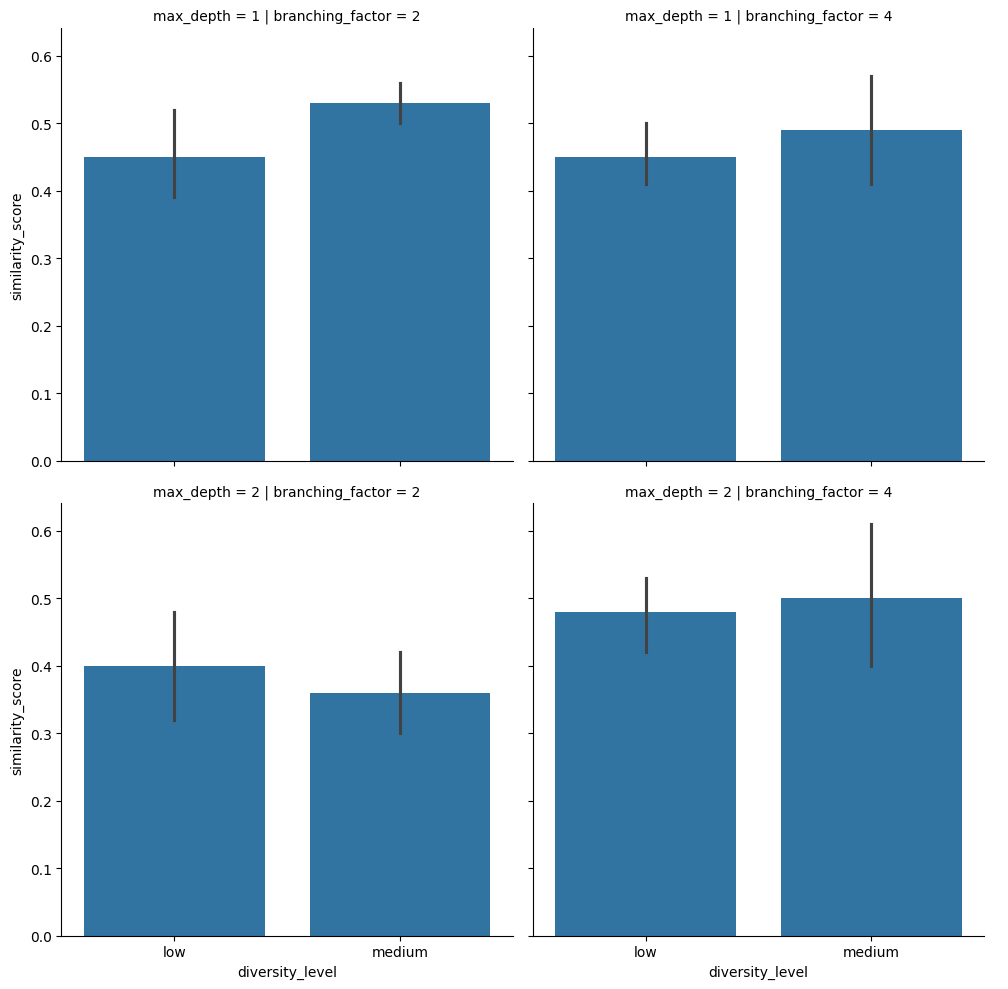

In [22]:
sns.catplot(data=df, x='diversity_level', y='similarity_score', 
            col='branching_factor', 
            row = "max_depth",
            kind='bar') 

In [23]:
def load_experiment_data(filename):
    """Load experiment results from a JSON file."""
    print(f"Loading data from {filename}...")
    
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Handle all_results file format
    if isinstance(data, list):
        results = data
    # Handle analysis file format
    elif 'summary' in data:
        experiment_id = data.get('experiment_id')
        all_results_file = os.path.join(os.path.dirname(filename), f"{experiment_id}_all_results.json")
        
        if os.path.exists(all_results_file):
            with open(all_results_file, 'r') as f:
                results = json.load(f)
        else:
            print("Error: Could not find all_results file")
            return None
    else:
        print("Error: Unrecognized file format")
        return None
    
    # Create DataFrame
    rows = []
    for result in results:
        # Skip results with errors
        if 'error' in result:
            continue
            
        row = {
            'query': result.get('query', ''),
            'similarity_score': result.get('similarity_score', 0),
            'diversity_level': result.get('ibfs_config', {}).get('diversity_level', ''),
            'branching_factor': result.get('ibfs_config', {}).get('branching_factor', 0),
            'max_depth': result.get('ibfs_config', {}).get('max_depth', 0),
            'epsilon': result.get('user_config', {}).get('epsilon', 0),
            'experiment_id': result.get('experiment_id', ''), 
            'pref_answer':result.get('user_preferred_answer', ''), 
            'final_answer':result.get('final_answer', '')
        }
        
        # Add strategy path information if available
        if 'strategy_path' in result:
            row['path_length'] = len(result.get('strategy_path', []))
        
        rows.append(row)
    
    df = pd.DataFrame(rows)
    print(f"Loaded {len(df)} valid results")
    return df

fn = "experiment_results/exp_20250319_160627_all_results.json"
df = load_experiment_data(fn)

Loading data from experiment_results/exp_20250319_160627_all_results.json...
Loaded 80 valid results


In [28]:
import pandas as pd
import numpy as np
import json
import os
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from rapidfuzz.distance import Levenshtein

# Ensure NLTK data is available
nltk.download('punkt')

# Load experiment data function
def load_experiment_data(filename):
    """Load experiment results from a JSON file."""
    
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Handle all_results file format
    if isinstance(data, list):
        results = data
    # Handle analysis file format
    elif 'summary' in data:
        experiment_id = data.get('experiment_id')
        all_results_file = os.path.join(os.path.dirname(filename), f"{experiment_id}_all_results.json")
        
        if os.path.exists(all_results_file):
            with open(all_results_file, 'r') as f:
                results = json.load(f)
        else:
            return None
    else:
        return None
    
    # Create DataFrame
    rows = []
    for result in results:
        if 'error' in result:
            continue
            
        row = {
            'query': result.get('query', ''),
            'similarity_score': result.get('similarity_score', 0),
            'diversity_level': result.get('ibfs_config', {}).get('diversity_level', ''),
            'branching_factor': result.get('ibfs_config', {}).get('branching_factor', 0),
            'max_depth': result.get('ibfs_config', {}).get('max_depth', 0),
            'epsilon': result.get('user_config', {}).get('epsilon', 0),
            'experiment_id': result.get('experiment_id', ''), 
            'pref_answer': result.get('user_preferred_answer', ''), 
            'final_answer': result.get('final_answer', '')
        }
        
        if 'strategy_path' in result:
            row['path_length'] = len(result.get('strategy_path', []))
        
        rows.append(row)
    
    df = pd.DataFrame(rows)
    return df

# Load dataset
fn = "experiment_results/exp_20250319_160627_all_results.json"
df = load_experiment_data(fn)

# Ensure pref_answer and final_answer exist
df = df.dropna(subset=['pref_answer', 'final_answer'])

# Cosine similarity using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['pref_answer'].tolist() + df['final_answer'].tolist())
tfidf_pref = tfidf_matrix[:len(df)]
tfidf_final = tfidf_matrix[len(df):]
df['cosine_similarity'] = [cosine_similarity(tfidf_pref[i], tfidf_final[i])[0, 0] for i in range(len(df))]

# Levenshtein Distance (normalized)
df['levenshtein_distance'] = df.apply(lambda row: Levenshtein.distance(row['pref_answer'], row['final_answer']), axis=1)
df['levenshtein_ratio'] = df.apply(lambda row: Levenshtein.normalized_similarity(row['pref_answer'], row['final_answer']), axis=1)

# Jaccard Similarity
def jaccard_similarity(str1, str2):
    set1, set2 = set(str1.split()), set(str2.split())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

df['jaccard_similarity'] = df.apply(lambda row: jaccard_similarity(row['pref_answer'], row['final_answer']), axis=1)

# BLEU Score
df['bleu_score'] = df.apply(lambda row: sentence_bleu(
    [nltk.word_tokenize(row['pref_answer'])], 
    nltk.word_tokenize(row['final_answer']),
    weights=(0.5, 0.5, 0, 0)), axis=1)  # Bi-gram BLEU score

# ROUGE Score
rouge = Rouge()
df['rouge_score'] = df.apply(lambda row: rouge.get_scores(row['final_answer'], row['pref_answer'])[0]['rouge-l']['f'], axis=1)


[nltk_data] Downloading package punkt to /Users/jashkina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/jashkina/Documents/LocResearch/ibfs/ibfs_project/.venv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/jashkina/Documents/LocResearch/ibfs/ibfs_project/.venv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


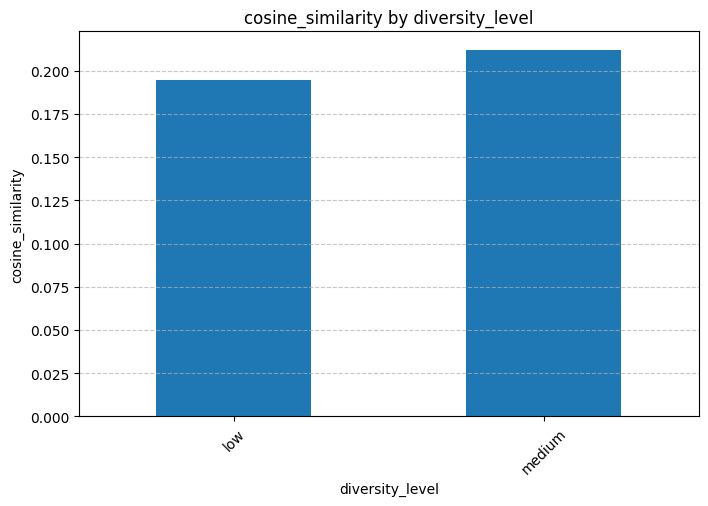

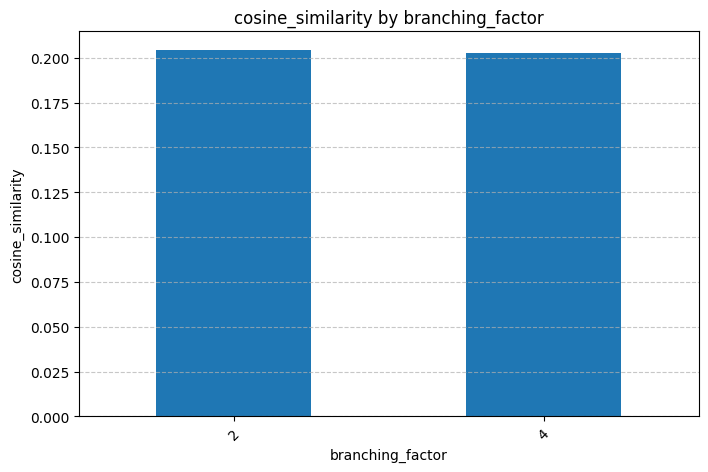

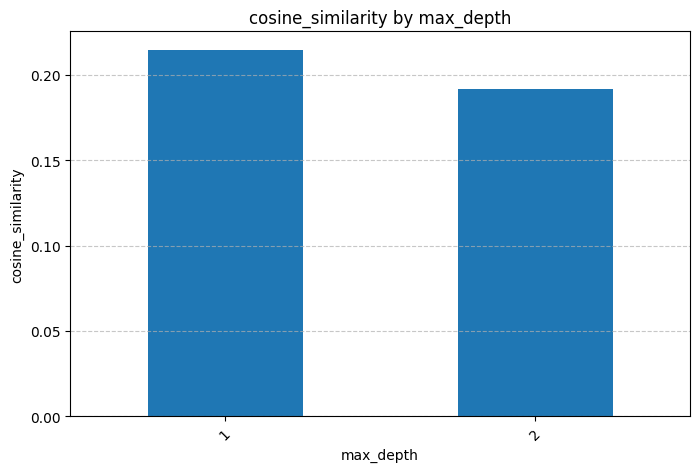

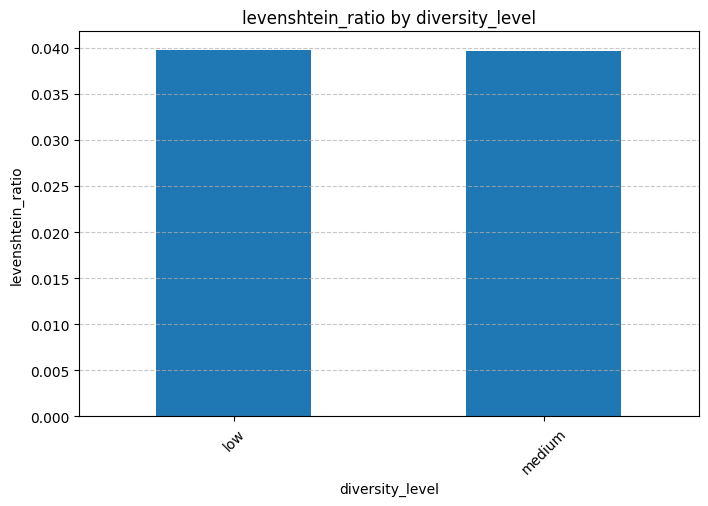

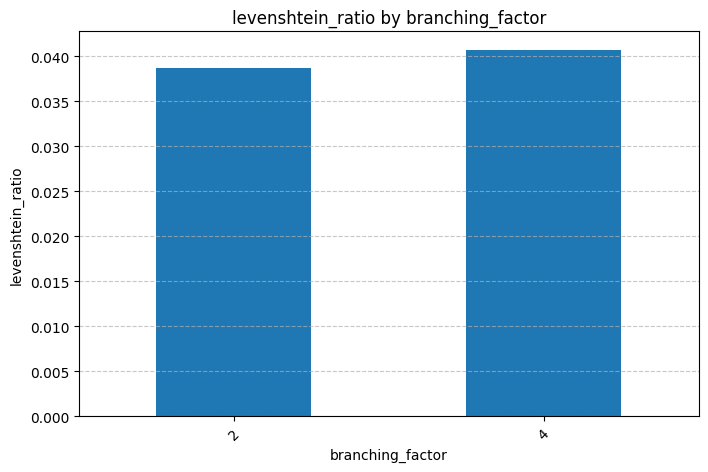

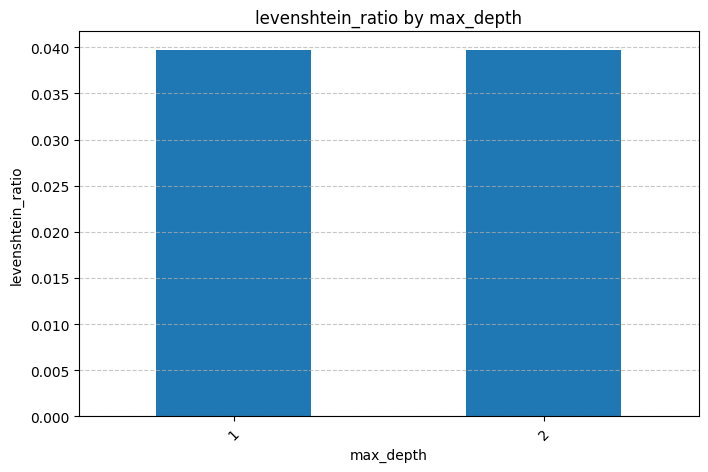

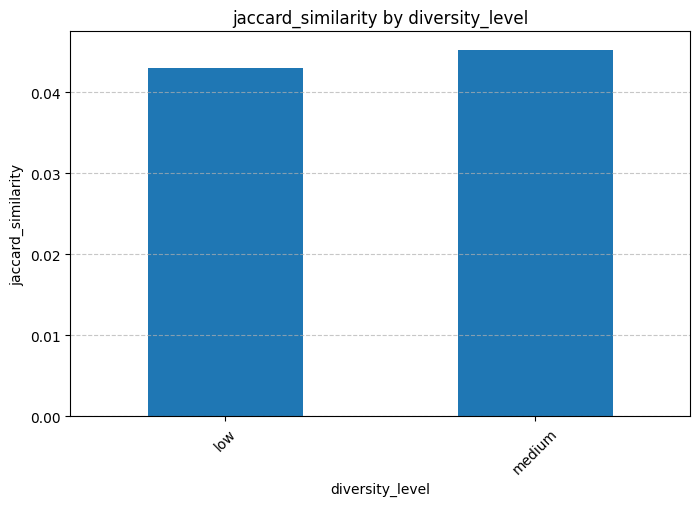

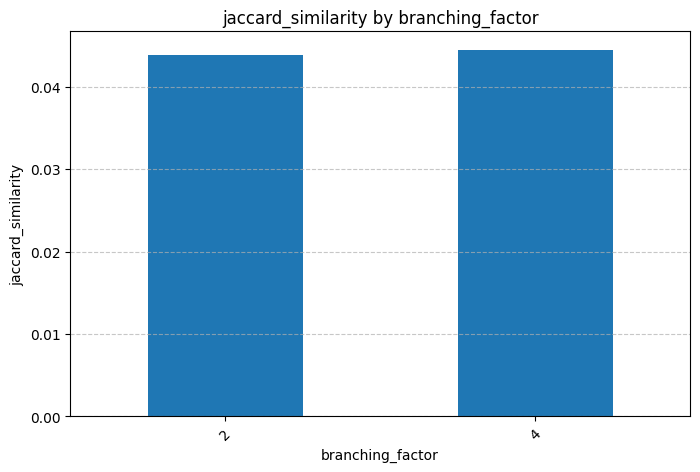

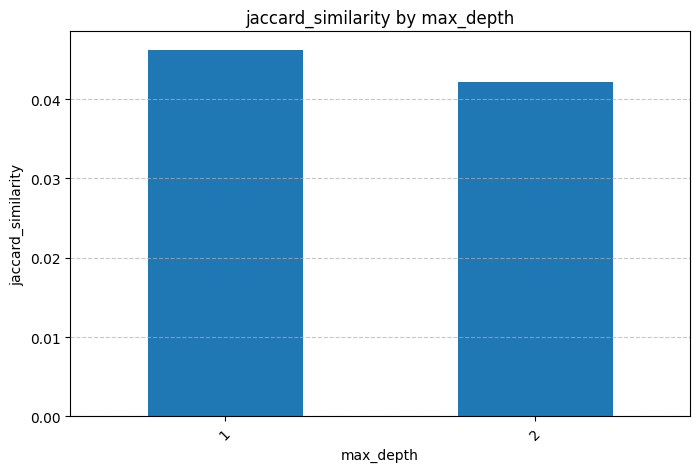

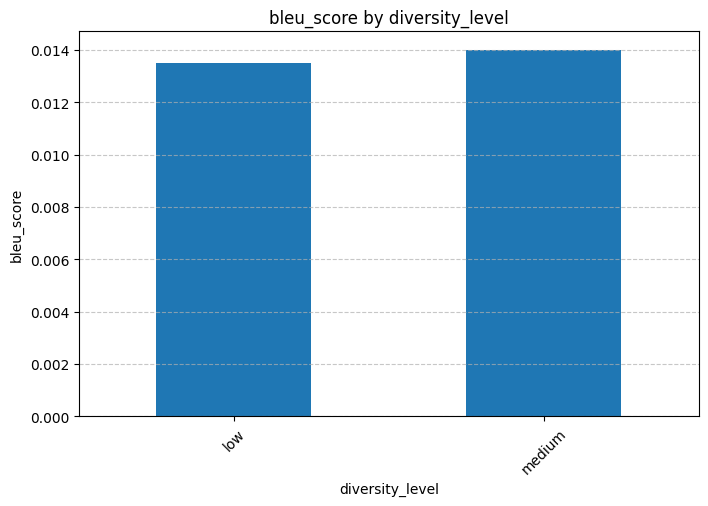

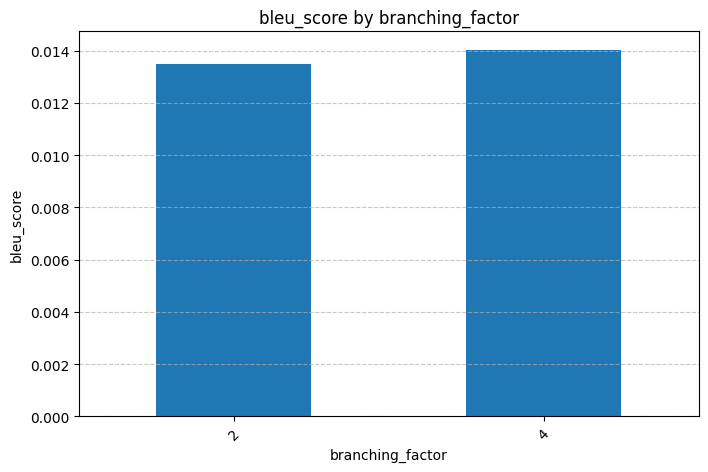

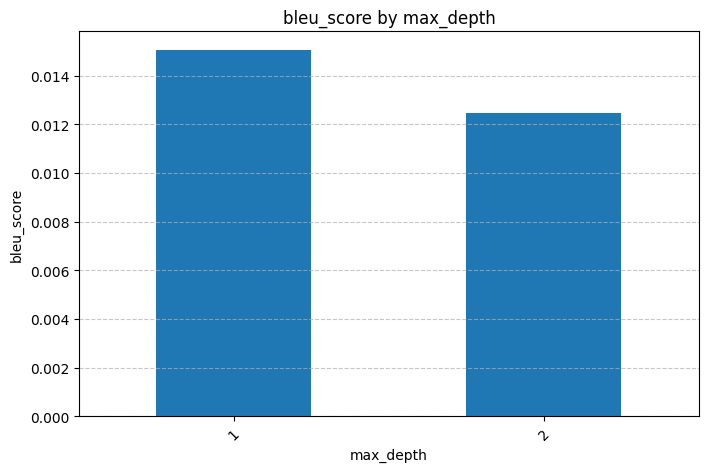

In [30]:
import matplotlib.pyplot as plt

# Define similarity metrics
metrics = ['cosine_similarity', 'levenshtein_ratio', 'jaccard_similarity', 'bleu_score']

# Define parameters to analyze
parameters = ['diversity_level', 'branching_factor', 'max_depth']

# Convert categorical columns to strings for proper grouping
df['diversity_level'] = df['diversity_level'].astype(str)
df['branching_factor'] = df['branching_factor'].astype(str)
df['max_depth'] = df['max_depth'].astype(str)

# Create bar charts for each metric across parameters
for metric in metrics:
    for param in parameters:
        plt.figure(figsize=(8, 5))
        df.groupby(param)[metric].mean().plot(kind='bar', title=f'{metric} by {param}')
        plt.ylabel(metric)
        plt.xlabel(param)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


<Axes: >

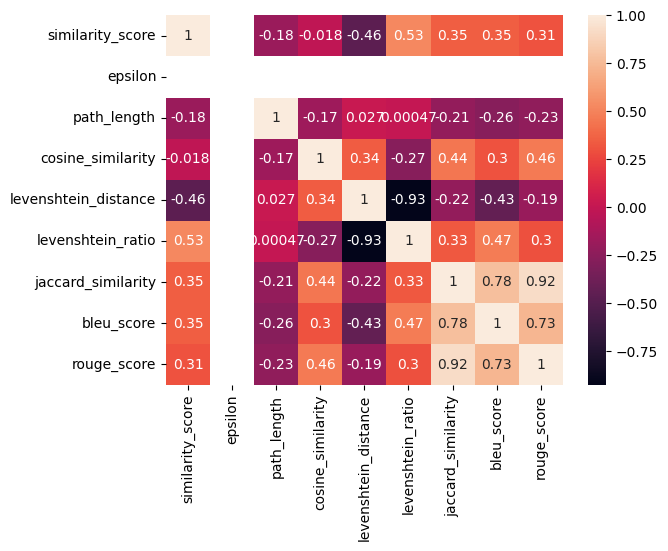

In [33]:
sns.heatmap(df.corr(numeric_only=True), annot=True)